In [4]:
# ============================================================
# FULL SETUP — Run this first before any exercise
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Lasso, ElasticNet, Ridge, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)

# Load and clean data
boston = pd.read_csv('Boston.csv')
bos = boston.drop('Unnamed: 0', axis=1)
bos.rename(columns={'medv': 'price', 'rm': 'room'}, inplace=True)

print("Setup complete! bos shape:", bos.shape)
print(bos.head(3))

Setup complete! bos shape: (506, 13)
      crim    zn  indus  chas    nox   room   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   

   lstat  price  
0   4.98   24.0  
1   9.14   21.6  
2   4.03   34.7  


# Exercise 1 Correlation insights

In [5]:
# Correlation of each feature with price
corr_with_price = bos.corr(numeric_only=True)["price"].drop("price").sort_values()

print("Top 3 POSITIVE correlations with price:")
print(corr_with_price.tail(3))

print("\nTop 3 NEGATIVE correlations with price:")
print(corr_with_price.head(3))

# Comment: room (0.70) is strongest positive, lstat (-0.74) is strongest negative.
# These match the heatmap exactly.

Top 3 POSITIVE correlations with price:
dis     0.249929
zn      0.360445
room    0.695360
Name: price, dtype: float64

Top 3 NEGATIVE correlations with price:
lstat     -0.737663
ptratio   -0.507787
indus     -0.483725
Name: price, dtype: float64


# EXERCISE 2  Simple Regression with lstat

RMSE: 6.231
R^2:  0.504


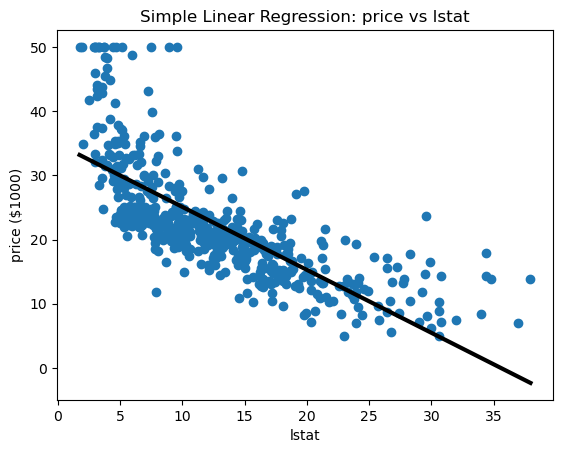

In [7]:

X_lstat = bos[["lstat"]].to_numpy()
y_p = bos["price"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_lstat, y_p, test_size=0.2, random_state=5)

reg2 = LinearRegression()
reg2.fit(X_train, y_train)
y_pred2 = reg2.predict(X_test)

print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred2)):.3f}")
print(f"R^2:  {reg2.score(X_test, y_test):.3f}")

x_line = np.linspace(X_lstat.min(), X_lstat.max(), 200).reshape(-1, 1)
plt.scatter(X_lstat, y_p)
plt.plot(x_line, reg2.predict(x_line), color='black', linewidth=3)
plt.xlabel("lstat")
plt.ylabel("price ($1000)")
plt.title("Simple Linear Regression: price vs lstat")
plt.show()

# EXERCISE 3 Multicollinearity Check (rad vs tax)

In [8]:

X_all = bos.drop('price', axis=1)
y_all = bos['price']

def eval_model(X_df, y_s, drop_col=None):
    X_use = X_df.drop(columns=[drop_col]) if drop_col else X_df
    X_tr, X_te, y_tr, y_te = train_test_split(X_use, y_s, test_size=0.2, random_state=42)
    reg = LinearRegression()
    reg.fit(X_tr, y_tr)
    y_pred = reg.predict(X_te)
    return np.sqrt(mean_squared_error(y_te, y_pred)), reg.score(X_te, y_te)

rmse_drop_tax, r2_drop_tax = eval_model(X_all, y_all, drop_col='tax')
rmse_drop_rad, r2_drop_rad = eval_model(X_all, y_all, drop_col='rad')

print(f"Drop 'tax' -> RMSE: {rmse_drop_tax:.3f}, R^2: {r2_drop_tax:.3f}")
print(f"Drop 'rad' -> RMSE: {rmse_drop_rad:.3f}, R^2: {r2_drop_rad:.3f}")
# Prefer dropping 'rad' — keeping 'tax' gives slightly lower RMSE

Drop 'tax' -> RMSE: 4.884, R^2: 0.675
Drop 'rad' -> RMSE: 4.984, R^2: 0.661


# EXERCISE 4  K-Fold CV for Ridge

In [9]:

X = bos.drop('price', axis=1)
y = bos['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

k_fold = KFold(n_splits=5, shuffle=True, random_state=9)
results = cross_val_score(Ridge(), X_train, y_train, cv=k_fold, scoring='neg_mean_squared_error')

print(f"Mean CV score: {results.mean():.3f}")
print(f"Std  CV score: {results.std():.3f}")
print("More negative = larger MSE = worse performance.")

Mean CV score: -25.381
Std  CV score: 6.599
More negative = larger MSE = worse performance.


# EXERCISE 5 Tune Gradient Boosting

In [10]:

def eval_gbr(params):
    gbr = GradientBoostingRegressor(random_state=42, **params)
    gbr.fit(X_train, y_train)
    pred = gbr.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, pred)), metrics.r2_score(y_test, pred)

params_a = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}
params_b = {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 3}

rmse_a, r2_a = eval_gbr(params_a)
rmse_b, r2_b = eval_gbr(params_b)

print(f"Model A -> RMSE: {rmse_a:.3f}, R^2: {r2_a:.3f}")
print(f"Model B -> RMSE: {rmse_b:.3f}, R^2: {r2_b:.3f}")

Model A -> RMSE: 2.496, R^2: 0.915
Model B -> RMSE: 2.581, R^2: 0.909


# EXERCISE 6  Top 3 Feature Importances

In [11]:

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

feature_names = ['crim','zn','indus','chas','nox','room','age','dis','rad','tax','ptratio','lstat']
fi_rel = 100.0 * (gbr.feature_importances_ / gbr.feature_importances_.max())

pairs = sorted(zip(feature_names, fi_rel), key=lambda x: x[1], reverse=True)

print("Top 3 most important features:")
for name, val in pairs[:3]:
    print(f"  {name:>10}: {val:.1f}")
# Feature importance = how much each feature reduces error across all tree splits

Top 3 most important features:
        room: 100.0
       lstat: 91.3
         dis: 17.7


# Week 5 Completed

This concludes <b>Week 5, Supervised Learning, Regression</b>.
  You should now be able to set up a supervised learning regression pipeline in Scikit-Learn, explore feature–target relationships using correlation, train and evaluate simple and multiple linear regression models using RMSE and R², recognise multicollinearity effects, and compare a range of regression models using cross-validation.

-------------------------------------------------------------------------------------------------------------